# Clustering of voxels and ROI based on beta maps

## Importing

In [7]:
import os
import glob
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import nistats
import scipy
import seaborn as sns
import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.regions import RegionExtractor
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf
from utils import *
import hdbscan
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import FastICA 
from sklearn import manifold
from sklearn.neighbors import kneighbors_graph

In [8]:
from logger import Logger
from utils import read_yaml, check_folder, fetch_masker, possible_subjects_id, get_subject_name
import reporting
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

## Defining global variables

In [9]:
language = 'english'

In [10]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_95%_{language}"
SMOOTHED_MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/smoothed_global_masker_{language}"

In [11]:
#PROJECT_PATH = f"/Users/alexpsq/Code/Parietal/maps"

In [12]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

In [13]:
path_to_beta_maps_template = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/{subject_name}/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_coef_.npy"
mask_template = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/{subject_name}/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_R2.nii.gz"
#path_to_beta_maps_template = "/Users/alexpsq/Code/Parietal/maps/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_coef_.npy"
#mask_template = "/Users/alexpsq/Code/Parietal/maps/{subject_name}_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{subject_id}_hidden-all-layers_R2.nii.gz"

In [14]:
#saving_folder = "/Users/alexpsq/Code/Parietal/maps/"
saving_folder =  "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/"

In [15]:
all_reduction_method = ["umap", "pca", "ica", "isomap"] # "none", "mds", "sp-emb"
all_clustering_method = ["hdbscan", "agg-clus", "max"]

In [37]:
params = {
        'data':None, 
        'reduction':'umap', 
        'clustering':'hdbscan', 
        'mask':None, 
        'min_cluster_size':50, 
        'min_samples':10, 
        'n_neighbors':4, 
        'min_dist':0.0, 
        'n_components':7, 
        'n_clusters':13, 
        'random_state':1111, 
        'cluster_selection_epsilon':0.5, 
        'affinity_reduc' : 'nearest_neighbors',
        'affinity_cluster':'cosine', 
        'linkage':'average',
        'saving_folder': None,
        'plot_name': None
}

## Functions definition

In [38]:
def heat_map(path_to_beta_maps, aggregate=False, title='', saving_path=None):
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps)
    else:
        data = path_to_beta_maps
    plt.figure(figsize=(40,40))
    if aggregate:
        data = aggregate_beta_maps(data, nb_layers=13, layer_size=768)
    sns.heatmap(data)
    plt.title('Heatmap -', title)
    if saving_path is not None:
        plt.savefig(saving_path)
        plt.close()
    else:
        plt.show()

In [39]:
def resample_beta_maps(path_to_beta_maps, original_masker, new_masker):
    """Resample beta map with a new masker.
    path_to_beta_maps: #voxels x #features"""
    if isinstance(original_masker, str):
        original_masker = load_masker(original_masker)
    if isinstance(new_masker, str):
        new_masker = load_masker(new_masker)
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps)
    else:
        data = path_to_beta_maps
    print("Original data has dimension: ", data.shape)
    imgs = original_masker.inverse_transform([data[:, i] for i in range(data.shape[1])])
    new_data = new_masker.transform(imgs) # dimension: #samples x #voxels
    print("New data has dimension: ", new_data.T.shape)
    return new_data.T
    

In [40]:
def create_subject_mask(mask_template, subject_name, subject_id, global_masker, threshold=75):
    mask_img = nib.load(mask_template.format(subject_name=subject_name, subject_id=subject_id))
    mask_tmp = global_masker.transform(mask_img)
    mask = np.zeros(mask_tmp.shape)
    mask[mask_tmp > np.percentile(mask_tmp, threshold)] = 1
    mask = mask.astype(int)
    mask = mask[0].astype(bool)
    return mask

In [41]:
def aggregate_beta_maps(data, nb_layers=13, layer_size=768):
    """Clustering of voxels or ROI based on their beta maps.
    maps: (#voxels x #features)
    """
    if isinstance(data, str):
        data = np.load(data)
    nb_layers = nb_layers
    layer_size = layer_size
    result = np.zeros((data.shape[0], nb_layers))
    for index in range(nb_layers):
        result[:, index] = np.mean(data[:, layer_size * index : layer_size * (index + 1)], axis=1)
    return result

In [42]:
def plot_roi_img_surf(surf_img, saving_path, plot_name, mask=None, labels=None, inflated=False, compute_surf=True, colorbar=True, **kwargs):
    fsaverage = datasets.fetch_surf_fsaverage()
    if compute_surf:
        surf_img = vol_to_surf(surf_img, fsaverage[kwargs['surf_mesh']], interpolation='nearest', mask_img=mask)
        surf_img[np.isnan(surf_img)] = -2
    if labels is not None:
        surf_img = np.round(surf_img)
        
    surf_img += 2
    if saving_path:
        plt.close('all')
        plt.hist(surf_img, bins=50)
        plt.title(plot_name)
        plt.savefig(saving_path + "hist_{}.png".format(plot_name))
    plt.close('all')
    if inflated:
        kwargs['surf_mesh'] = 'infl_left' if 'left' in kwargs['surf_mesh_type'] else 'infl_right' 
    disp = plotting.plot_surf_roi(
        surf_mesh=fsaverage[kwargs['surf_mesh']], 
        roi_map=surf_img,
        hemi=kwargs['hemi'],
        view=kwargs['view'],
        bg_map=fsaverage[kwargs['bg_map']], 
        bg_on_data=kwargs['bg_on_data'],
        darkness=kwargs['darkness'],
        colorbar=colorbar)
    if saving_path:
        disp.savefig(saving_path + plot_name + '_{}_{}_{}.png'.format(kwargs['surf_mesh_type'], kwargs['hemi'], kwargs['view']))
    else:
        plotting.show()

In [43]:
def scatter3d(data, cs, colorsMap='jet', reduction_type='', other=None, **kwargs):
    """3D scatter plot with random color to distinguish the shape."""
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', c=scalarMap.to_rgba(cs), **kwargs)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(other['elevation'], other['azimuth'])

    #ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.title('Activations embedding for {}'.format(reduction_type), fontsize=24)
    ax.view_init(other['elevation'], other['azimuth'])
    interact()

In [44]:
def plot_reduction(data, plot_type='2D', reduction_type='', other=None, **kwargs):
    """kwargs includes: 
     - s=5
     - c='density'
     - cmap='Spectral'
    """
    plt.close('all')
    if plot_type=='2D':
        plt.scatter(data[:, 0], data[:, 1], **kwargs)
        interact()
    elif plot_type=='3D':
        scatter3d(data, results, colorsMap='jet', reduction_type=reduction_type, other=other, **kwargs)

In [45]:
def plot_reduc(path_to_beta_maps, n_neighbors=30, min_dist=0.0, n_components=3, random_state=1111, cluster_selection_epsilon=0.0):
    """Clustering of voxels or ROI based on their beta maps.
    """
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps).T
    else:
        data = path_to_beta_maps.T
    
    plot_kwargs = {
        's':2,
        #'c':'density',
        'cmap':'Spectral'
    }
    data = data.T
    print("UMAP...")
    umap_result_3D = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state, metric='manhattan').fit_transform(data)
    plot_reduction(umap_result_3D, plot_type='3D', reduction_type='UMAP', other={'elevation': 15, 'azimuth': 15}, **plot_kwargs)
    

In [112]:
def clustering(data, mask, reduction, clustering, min_cluster_size=20, min_samples=10, n_neighbors=30, min_dist=0.0, n_components=10, n_clusters=13, random_state=1111, cluster_selection_epsilon=0.0, affinity_reduc='nearest_neighbors', affinity_cluster='cosine', linkage='average', saving_folder=None, plot_name=None, metric='cosine'):
    """Clustering of voxels or ROI based on their beta maps.
    """    
    if reduction=="umap":
        data_reduced = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state, metric=metric).fit_transform(data)
        standard_embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=random_state, metric=metric).fit_transform(data)
    elif reduction=="pca":
        data_reduced = PCA(n_components=n_components, random_state=random_state).fit_transform(data)
        standard_embedding = PCA(n_components=2, random_state=random_state).fit_transform(data)
    elif reduction=="ica":
        data_reduced = FastICA(n_components=n_components, random_state=random_state).fit_transform(data)
        standard_embedding = FastICA(n_components=2, random_state=random_state).fit_transform(data)
    elif reduction=="isomap":
        data_reduced = manifold.Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1).fit_transform(data)
        standard_embedding = manifold.Isomap(n_components=2, n_neighbors=n_neighbors, n_jobs=-1).fit_transform(data)
    elif reduction=="mds":
        data_reduced = manifold.MDS(n_components=n_components, random_state=random_state, n_jobs=-1).fit_transform(data)
        standard_embedding = manifold.MDS(n_components=2, random_state=random_state, n_jobs=-1).fit_transform(data)
    elif reduction=="sp-emb":
        data_reduced = manifold.SpectralEmbedding(n_components=n_components, random_state=random_state, n_neighbors=n_neighbors, n_jobs=-1).fit_transform(data)
        standard_embedding = manifold.SpectralEmbedding(n_components=2, random_state=random_state, n_neighbors=n_neighbors, n_jobs=-1, affinity=affinity_reduc).fit_transform(data)
    else:
        data_reduced = data
    if clustering=='hdbscan':
        labels_ = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon).fit_predict(data_reduced)
    elif clustering=='agg-clus':
        #kneighbors_graph_ = kneighbors_graph(data_, n_neighbors=5)
        sc = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity_cluster) #  connectivity=kneighbors_graph_
        clustering = sc.fit(data_reduced)
        labels_ = clustering.labels_
    elif clustering=="max":
        labels_ = np.argmax(data_reduced, axis=1)
    all_labels = np.zeros(len(mask))
    all_labels[mask] = labels_
    all_labels[~mask] = -2
    
    # Printing scatter plot
    if reduction in ["umap", "pca", "ica", "isomap", "mds", "sp-emb"]:
        plt.close('all')
        clustered = (labels_ >= 0)
        colorsMap='jet'
        cm = plt.get_cmap(colorsMap)
        cNorm = matplotlib.colors.Normalize(vmin=min(labels_), vmax=max(labels_))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

        plt.scatter(standard_embedding[clustered, 0],
                    standard_embedding[clustered, 1],
                    c=scalarMap.to_rgba(labels_[clustered]),
                    s=0.1,
                    cmap='Spectral')
        plot_name += '_nb_clusters-{}_non-null-{}'.format(len(np.unique(all_labels)), np.sum(all_labels>0))
        plt.title(plot_name)
        check_folder(saving_folder)
        if saving_folder is not None:
            plt.savefig(saving_folder + "scatter_{}.png".format(plot_name))
        plt.show()
        plt.close('all')
        
    return all_labels

In [113]:
def create_name(subject_name, params):
    keys = [
            'reduction',
            'clustering',
            'min_cluster_size',
            'n_neighbors',
            'n_components',
            'affinity_cluster',
            'linkage',
            'min_samples',
            'metric'
    ]
    name = subject_name
    for key in keys:
        name += '_' + key + '-' + str(params[key])
    return name

In [114]:
def save_results(data, all_original_length, saving_folder, plot_name, global_masker, mask, **kwargs):
    """Save surface plot."""
    plot_name += '_nb_clusters-{}_non-null-{}'.format(len(np.unique(data)), np.sum(data>0))
    if saving_folder is not None:
        check_folder(os.path.join(saving_folder, 'labels'))
        np.save(os.path.join(saving_folder, 'labels', plot_name+'.npy'), data)
    i = 0
    results = []
    nb_clusters = len(np.unique(data))
    print('Input shape: ', data.shape)
    print('Number of clusters: ', nb_clusters)
    for l in all_original_length:
        results.append(get_prob_matrix(data[i: i+l], nb_clusters))
        i += l
    l = results[0].shape[1]
    print('Number of voxels:', l)
    for index, item in enumerate(results):
        assert item.shape[1]==l
    matrix_ = np.stack(results, axis=0)
    prob_matrix = np.mean(matrix_, axis=0)
    argmax_matrix = np.argmax(prob_matrix, axis=0)
    #final_matrix = np.zeros((nb_clusters, len(argmax_matrix)))
    #for index, i in enumerate(rois):
    #    final_matrix[i, index] = 1
    
    img = global_masker.inverse_transform(argmax_matrix)
    plot_roi_img_surf(img, saving_folder, plot_name, mask=global_masker.inverse_transform(mask), labels=np.unique(results), inflated=False, compute_surf=True, colorbar=True, **kwargs)


In [49]:
def get_connectivity_matrix(labels):
    if isinstance(labels, str):
        labels = np.load(labels)
    result = np.equal.outer(labels,labels).astype(int)
    return result

In [50]:
def get_prob_matrix(labels, nb_clusters):
    if isinstance(labels, str):
        labels = np.load(labels)
    nb_voxels = len(labels)
    prob_matrix = np.zeros((nb_clusters, nb_voxels))
    for index, i in enumerate(range(nb_clusters)):
        prob_matrix[index, labels==i] = 1
    return prob_matrix

In [51]:
def get_labels(subject_name, reduction, clustering, saving_folder, params):
    """Retrieve computed labels for a given subject."""
    saving_folder = os.path.join(saving_folder, '_'.join([reduction, clustering]) + '/')
    plot_name = create_name(subject_name, params)
    path = sorted(glob.glob(os.path.join(saving_folder, 'labels', plot_name + '*.npy')))
    return path

In [52]:
def get_images(subject_name, reduction, clustering, saving_folder, params):
    """Retrieve computed labels for a given subject."""
    saving_folder = os.path.join(saving_folder, '_'.join([reduction, clustering]) + '/')
    plot_name = create_name(subject_name, params)
    path = sorted(glob.glob(os.path.join(saving_folder, plot_name + '*.png')))
    return path

## Data Loading

In [53]:
global_masker_50 = reporting.fetch_masker(f"{PROJECT_PATH}/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"{PROJECT_PATH}/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

In [54]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'
x_labels = labels[1:]

In [55]:
subjects = [get_subject_name(sub_id) for sub_id in possible_subjects_id(language)]

In [56]:
#reporting.plot_roi_img_surf(global_masker_50.inverse_transform(global_masker_50.transform("/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/sub-057/bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_57_hidden-all-layers/sub-057_bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_57_hidden-all-layers_R2.nii.gz")), None, 'test', inflated=False, compute_surf=True, colorbar=True, **kwargs)


## Defining subjects variables

In [31]:
subject_name="sub-057"
subject_id="57"
original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)

NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f7c589fa210>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=0, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

In [32]:
path_to_beta_maps = path_to_beta_maps_template.format(subject_name=subject_name, subject_id=subject_id)
mask = create_subject_mask(mask_template, subject_name, subject_id, global_masker_95, threshold=75)

In [33]:
view = 'left' #left
kwargs = {
    'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
    'surf_mesh_type': f'pial_{view}',
    'hemi': view, # right
    'view':'lateral', # medial
    'bg_map': f'sulc_{view}', # sulc_right
    'bg_on_data':True,
    'darkness':.8
}

In [34]:
# Parameters
n_components_list = [3, 4, 7, 10] # 
n_clusters_list = [3, 4, 5, 6, 10]
min_samples = 10
min_cluster_size = 50 #
n_neighbors_list = [3, 4]
cluster_selection_epsilon = 0.5
min_dist = 0.0
#affinity_list_SE = 'nearest_neighbors' #(for spectral_embedding, no difference with 'rbf')
affinity_list_AC = ["cosine"] #(for agglomerative clustering) other metrics:  "l1", "l2", "manhattan", 
linkage_list = ['ward', 'complete'] # 'average'

In [35]:
all_clustering_method = ['agg-clus', 'max']
all_reduction_method = ['umap', 'pca', 'ica', 'isomap']

In [36]:
iterator = [('umap', 'hdbscan')] + list(itertools.product(*[all_reduction_method, all_clustering_method]))

## Evaluation of all models

In [206]:
params.update({'data': resample_beta_maps(aggregate_beta_maps(path_to_beta_maps, nb_layers=13, layer_size=768), original_masker, new_masker),
              'mask': mask})

for reduction_method, clustering_method in iterator:
    params.update({'saving_folder': os.path.join(saving_folder, '_'.join([reduction_method, clustering_method]) + '/')})
    for n_components in n_components_list:
        for n_clusters in n_clusters_list:
            for n_neighbors in n_neighbors_list:
        #if n_components > n_clusters:
                params.update({'reduction':reduction_method,
                               'clustering':clustering_method, 
                               'n_components':n_components,
                               'n_clusters':n_clusters,
                               'min_samples': min_samples,
                               'min_cluster_size': min_cluster_size,
                               'cluster_selection_epsilon': cluster_selection_epsilon,
                               'min_dist': min_dist,
                               'n_neighbors': n_neighbors
                              })
                print("reduction_method: ", reduction_method, '- clustering_method:', clustering_method)
                print('min_samples:', min_samples, '- min_cluster_size:', min_cluster_size, '- cluster_selection_epsilon:', cluster_selection_epsilon)
                print('n_neighbors:', n_neighbors, '- min_dist:', min_dist, '- n_components:', n_components, '- n_clusters:', n_clusters)
                if clustering_method=="agg-clus":
                    for linkage in linkage_list:
                        if linkage!='ward':
                            for affinity_cluster in affinity_list_AC:
                                params.update({'affinity_cluster': affinity_cluster, 'linkage': linkage})
                                plot_name = create_name(subject_name, params)
                                params.update({'plot_name': plot_name})
                                results = clustering(**params)
                                save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                        else:
                            params.update({'affinity_cluster': "euclidean", 'linkage': linkage})
                            plot_name = create_name(subject_name, params)
                            params.update({'plot_name': plot_name})
                            results = clustering(**params)
                            save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)
                else:
                    plot_name = create_name(subject_name, params)
                    params.update({'plot_name': plot_name})
                    results = clustering(**params)
                    save_results(results, params['saving_folder'], plot_name, global_masker_95, mask, **kwargs)


## Loop over subjects

In [99]:
params

{'data': array([[ 3.05821954e-06,  1.03257184e-07,  1.17698720e-06, ...,
         -1.64752808e-06, -1.05416780e-05,  1.78105042e-07],
        [-1.53837464e-06,  5.99221938e-08,  7.57781357e-07, ...,
         -1.52695328e-06, -1.70396835e-05,  1.45347150e-06],
        [ 1.32903441e-05, -5.51975342e-06, -1.74639329e-06, ...,
          3.11801822e-06,  4.17036457e-07,  2.76057167e-06],
        ...,
        [ 4.42373291e-05,  1.33730607e-05,  3.28934397e-06, ...,
          6.40353170e-06,  1.11998565e-05, -1.58832716e-06],
        [ 1.60131168e-05,  4.18155786e-06, -5.55135333e-08, ...,
          5.61078977e-07,  1.13640585e-06, -7.64459724e-07],
        [-1.10253892e-06, -1.60263999e-06, -5.24188306e-07, ...,
         -1.68598378e-06,  2.41015997e-06,  2.09688924e-06]]),
 'reduction': 'umap',
 'clustering': 'hdbscan',
 'mask': array([ True,  True,  True, ...,  True, False, False]),
 'min_cluster_size': 50,
 'min_samples': 10,
 'n_neighbors': 4,
 'min_dist': 0.0,
 'n_components': 7,
 'n_cl

In [58]:
params.update({'reduction': 'umap', 
               'clustering': 'hdbscan', 
               'n_clusters': 4, 
               'linkage': 'ward', 
               'affinity_cluster': 'euclidean'})

In [59]:
view = 'left' #left
kwargs = {
    'surf_mesh': f'pial_{view}', # pial_right, infl_left, infl_right
    'surf_mesh_type': f'pial_{view}',
    'hemi': view, # right
    'view':'lateral', # medial
    'bg_map': f'sulc_{view}', # sulc_right
    'bg_on_data':True,
    'darkness':.8
}

In [60]:
original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)

all_data = []
all_masks = []
all_original_length = []

for subject_name in tqdm(subjects):
    subject_id = int(subject_name.split('-')[-1])
    path_to_beta_maps = path_to_beta_maps_template.format(subject_name=subject_name, subject_id=subject_id)
    mask = create_subject_mask(mask_template, subject_name, subject_id, global_masker_95, threshold=75)
    
    data = np.load(path_to_beta_maps)
    all_masks.append(mask)
    all_data.append(resample_beta_maps(aggregate_beta_maps(np.vstack(data) if mask is not None else data.copy(), nb_layers=13, layer_size=768), original_masker, new_masker)[mask, :])
    all_original_length.append(data.shape[0] if mask is not None else data.copy().shape[0])

  0%|          | 0/51 [00:00<?, ?it/s]

Original data has dimension:  (26164, 13)


  2%|▏         | 1/51 [00:20<16:45, 20.10s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


  4%|▍         | 2/51 [00:40<16:22, 20.04s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


  6%|▌         | 3/51 [01:00<16:03, 20.07s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


  8%|▊         | 4/51 [01:20<15:40, 20.01s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 10%|▉         | 5/51 [01:44<16:16, 21.22s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 12%|█▏        | 6/51 [02:04<15:41, 20.93s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 14%|█▎        | 7/51 [02:24<15:05, 20.58s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 16%|█▌        | 8/51 [02:43<14:32, 20.30s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 18%|█▊        | 9/51 [03:03<14:03, 20.08s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 20%|█▉        | 10/51 [03:22<13:36, 19.93s/it]

New data has dimension:  (22378, 13)


 22%|██▏       | 11/51 [03:42<13:14, 19.86s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 24%|██▎       | 12/51 [04:02<12:50, 19.76s/it]

New data has dimension:  (22378, 13)


 25%|██▌       | 13/51 [04:21<12:30, 19.76s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 27%|██▋       | 14/51 [04:41<12:11, 19.76s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 29%|██▉       | 15/51 [05:01<11:48, 19.67s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 31%|███▏      | 16/51 [05:20<11:28, 19.67s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 33%|███▎      | 17/51 [05:40<11:13, 19.80s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 35%|███▌      | 18/51 [06:01<10:59, 19.97s/it]

New data has dimension:  (22378, 13)


 37%|███▋      | 19/51 [06:21<10:37, 19.94s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 39%|███▉      | 20/51 [06:41<10:18, 19.95s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 41%|████      | 21/51 [07:01<09:58, 19.96s/it]

New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 43%|████▎     | 22/51 [07:20<09:37, 19.92s/it]

New data has dimension:  (22378, 13)


 45%|████▌     | 23/51 [07:40<09:14, 19.80s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 47%|████▋     | 24/51 [07:59<08:51, 19.67s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 49%|████▉     | 25/51 [08:19<08:29, 19.60s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 51%|█████     | 26/51 [08:38<08:09, 19.57s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 53%|█████▎    | 27/51 [08:58<07:48, 19.52s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 55%|█████▍    | 28/51 [09:17<07:29, 19.53s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 57%|█████▋    | 29/51 [09:37<07:09, 19.53s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 59%|█████▉    | 30/51 [09:56<06:50, 19.54s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 61%|██████    | 31/51 [10:16<06:31, 19.56s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 63%|██████▎   | 32/51 [10:36<06:14, 19.72s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 65%|██████▍   | 33/51 [10:56<05:57, 19.86s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 67%|██████▋   | 34/51 [11:16<05:38, 19.90s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 69%|██████▊   | 35/51 [11:36<05:19, 19.98s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 71%|███████   | 36/51 [11:56<05:00, 20.02s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 73%|███████▎  | 37/51 [12:16<04:40, 20.03s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 75%|███████▍  | 38/51 [12:36<04:19, 19.93s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 76%|███████▋  | 39/51 [12:56<03:57, 19.82s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 78%|███████▊  | 40/51 [13:15<03:37, 19.75s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 80%|████████  | 41/51 [13:35<03:17, 19.72s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 82%|████████▏ | 42/51 [13:54<02:57, 19.68s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 84%|████████▍ | 43/51 [14:14<02:37, 19.69s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 86%|████████▋ | 44/51 [14:34<02:17, 19.67s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)
Original data has dimension:  (26164, 13)


 88%|████████▊ | 45/51 [14:53<01:57, 19.64s/it]

New data has dimension:  (22378, 13)


 90%|█████████ | 46/51 [15:13<01:37, 19.58s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 92%|█████████▏| 47/51 [15:33<01:18, 19.63s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 94%|█████████▍| 48/51 [15:52<00:59, 19.71s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 96%|█████████▌| 49/51 [16:12<00:39, 19.73s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


 98%|█████████▊| 50/51 [16:32<00:19, 19.73s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


100%|██████████| 51/51 [16:52<00:00, 19.85s/it]

Original data has dimension:  (26164, 13)
New data has dimension:  (22378, 13)


In [96]:
folder = os.path.join(PROJECT_PATH, 'test')
np.save(os.path.join(folder, 'all_masks.npy'), np.array(all_masks))
np.save(os.path.join(folder, 'all_data.npy'), np.array(all_data))
np.save(os.path.join(folder, 'all_original_length.npy'), np.array(all_original_length))

In [108]:
params.update({'reduction':'umap',
               'clustering':'hdbscan', 
               'n_components':3,
               'n_clusters':8,
               'min_samples': 10,
               'min_cluster_size': 30,
               'cluster_selection_epsilon': 0.5,
               'min_dist': 0.0,
               'n_neighbors': 3
                              })

In [109]:
params.update({'data': np.vstack(all_data),
               'mask': np.hstack(all_masks)
              })

params.update({'saving_folder': os.path.join(saving_folder, '_'.join([params['reduction'], params['clustering']]) + '/')})
plot_name = create_name('all-subjects', params)
params.update({'plot_name': plot_name})
print('Plot name:' , plot_name)

Plot name: all-subjects_reduction-umap_clustering-hdbscan_min_cluster_size-30_n_neighbors-3_n_components-3_affinity_cluster-euclidean_linkage-ward_min_samples-10


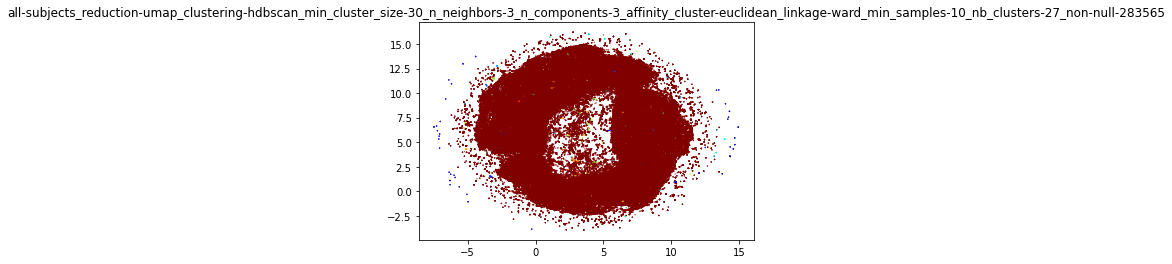

In [110]:
results = clustering(**params)

Input shape:  (1141278,)
Number of clusters:  27
Number of voxels: 22378


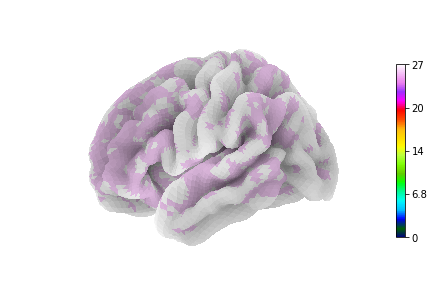

In [111]:
save_results(results, all_original_length, None, plot_name, global_masker_95, mask, **kwargs) #params['saving_folder']

In [ ]:
for n_components in [2, 3]:
    for n_neighbors in [2, 3, 100]:
        metric = 'cosine'
        params.update({'reduction':'umap',
                       'clustering':'hdbscan', 
                       'n_components':n_components,
                       'n_clusters':8,
                       'min_samples': 10,
                       'min_cluster_size': 50,
                       'cluster_selection_epsilon': 0.5,
                       'min_dist': 0.0,
                       'n_neighbors': n_neighbors,
                       'metric': metric
                                      })

        params.update({'saving_folder': os.path.join(saving_folder, '_'.join([params['reduction'], params['clustering']]) + '/')})
        plot_name = create_name('all-subjects', params)
        params.update({'plot_name': plot_name})
        print('Plot name:' , plot_name)
        results = clustering(**params)
        save_results(results, all_original_length, None, plot_name, global_masker_95, mask, **kwargs) #params['saving_folder']

Plot name: all-subjects_reduction-umap_clustering-hdbscan_min_cluster_size-50_n_neighbors-2_n_components-2_affinity_cluster-euclidean_linkage-ward_min_samples-10_metric-cosine


## Average atlas

In [53]:
params.update({'reduction': 'umap', 
               'clustering': 'hdbscan', 
               'n_clusters': '*', 
               'linkage': '*', 
               'affinity_cluster': '*'})
prob_matrices = []

for subject_name in tqdm(subjects):
    subject_id = int(subject_name.split('-')[-1])
    paths = get_labels(subject_name, params['reduction'], params['clustering'], saving_folder, params)
    for path in paths:
        prob_matrices.append(get_connectivity_matrix(path))

 63%|██████▎   | 32/51 [08:49<05:14, 16.55s/it]


MemoryError: Unable to allocate 3.73 GiB for an array with shape (22378, 22378) and data type int64

In [ ]:
prob_matrices[0].shape

In [121]:
matrix_ = np.stack(prob_matrices, axis=0)
matrix = np.mean(matrix_, axis=0)

In [118]:
rois = np.argmax(matrix, axis=0)

In [119]:
final_matrix = np.zeros((len(np.unique(rois)), len(rois)))
for index, i in enumerate(rois):
    final_matrix[i, index] = 1

In [101]:
plotting.plot_prob_atlas(
    global_masker_95.inverse_transform(final_matrix), 
    display_mode='ortho', 
    colorbar=False,
    cut_coords=(-58,-1, 20))
plotting.show()

/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


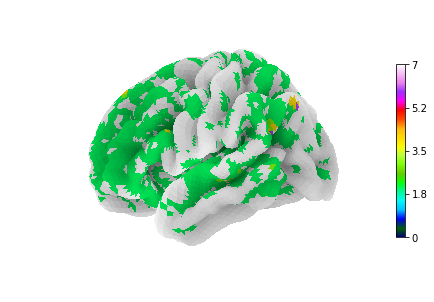

In [105]:
img = global_masker_95.inverse_transform(rois)
plot_roi_img_surf(img, 'None', 'plot_name', mask=global_masker_95.inverse_transform(mask), labels=np.unique(rois), inflated=False, compute_surf=True, colorbar=True, **kwargs)


In [128]:
from IPython.display import Image
for subject_name in subjects:
    images = get_images(subject_name, params['reduction'], params['clustering'], saving_folder, params)
    for image in images:
        Image(filename=image) 



## Analysis per ROI

In [ ]:
if global_mask and atlas_maps:
    global_masker = load_masker(global_mask)
    imgs = global_masker.inverse_transform([data[i, :] for i in range(data.shape[0])])
    data = np.zeros((data.shape[0], len(labels)-1))
    for index_mask in tqdm(range(len(labels)-1)):
        masker = get_roi_mask(atlas_maps, index_mask, labels, global_mask=global_mask)
        data[:, index_mask] = np.mean(masker.transform(imgs), axis=1)

## Visualization

In [ ]:
%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib


plot_reduc(
            aggregate_beta_maps(path_to_beta_maps, nb_layers=13, layer_size=768), 
            )